# Загрузка данных

In [7]:
import os
import pandas as pd

directory_path = './SLAM/'

# Получение списка файлов в директории
files = os.listdir(directory_path)

# Создание пустого DataFrame для объединения данных
combined_data = pd.DataFrame()

# Чтение данных из каждого файла и их объединение
for file in files:
    if file.endswith('.asc') and 'SLAM' in file:
        file_path = os.path.join(directory_path, file)
        data = pd.read_csv(file_path, delim_whitespace=True, skiprows=40, usecols=[0, 1, 2, 3, 4, 5, 6, 7], header=None)
        data.columns = ['YYYY', 'MM', 'DD', 'HH', 'MJD', 'SLAM_x', 'SLAM_y', 'SLAM_z']
        
        # Добавление данных к общему DataFrame
        combined_data = pd.concat([combined_data, data])

# Теперь у вас есть общий DataFrame combined_data, содержащий данные из всех файлов


In [8]:
combined_data

,YYYY,MM,DD,HH,MJD,SLAM_x,SLAM_y,SLAM_z
0,1976,1,1,12,42778.5,-3.677921e-08,-2.433173e-08,-1.880143e-09
1,1976,1,2,12,42779.5,-3.213873e-08,-2.150398e-08,-1.661230e-09
2,1976,1,3,12,42780.5,-2.898192e-08,-2.264260e-08,-1.698439e-09
3,1976,1,4,12,42781.5,-2.771356e-08,-2.614484e-08,-1.643318e-09
4,1976,1,5,12,42782.5,-2.492003e-08,-3.035349e-08,-1.595461e-09
...,...,...,...,...,...,...,...,...
338,2023,12,5,12,60283.5,-3.269094e-08,4.088133e-08,-7.479304e-11
339,2023,12,6,12,60284.5,-3.321108e-08,3.867317e-08,-9.581645e-11
340,2023,12,7,12,60285.5,-3.313038e-08,3.052533e-08,-1.121576e-10
341,2023,12,8,12,60286.5,-2.394557e-08,2.737645e-08,-1.153717e-10


## Анализ на стационарность ряда

Тест ADF (расширенный тест Дики — Фуллера) — проверка Статистической значимости (Statistical Significance), которая демонстрирует результаты проверки Нулевой гипотезы (Null Hypothesis) и Альтернативной (Alternative Hypothesis). В результате мы получим P-значение (P Value), из которого можно сделать вывод о Стационарности (Stationarity) Временного ряда (Time Series).

In [9]:
from statsmodels.tsa.stattools import adfuller

# series - ваш временной ряд
result = adfuller(combined_data['SLAM_x'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -5.923183157745242
p-value: 2.478649578666682e-07
Critical Values: {'1%': -3.430724413854906, '5%': -2.8617054764436287, '10%': -2.566858078818888}


ADF статистика (-5.92) меньше критических значений на всех уровнях значимости (1%, 5%, 10%).

P-value (2.48e-07) очень маленький, что также указывает на отклонение от нулевой гипотезы.

На основании этого теста есть статистические доказательства в пользу отвержения нулевой гипотезы о наличии единичного корня. 
Это означает, что у нас есть основания считать временной ряд стационарным.

## Разделение на выборки

In [20]:
import numpy as np

SLAM_x_array = combined_data['SLAM_x'].values
SLAM_y_array = combined_data['SLAM_y'].values
SLAM_z_array = combined_data['SLAM_z'].values

In [21]:
from sklearn.model_selection import train_test_split

train_size = 0.8  # Процентное соотношение для тренировочной выборки

train_data, validation_data = train_test_split(SLAM_x_array, train_size=train_size, shuffle=False)
train_data_y, validation_data_y = train_test_split(SLAM_y_array, train_size=train_size, shuffle=False)
train_data_z, validation_data_z = train_test_split(SLAM_z_array, train_size=train_size, shuffle=False)

# Определение количества шагов для прогнозирования
forecast_period = 90



## Обучение модели SARIMA

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Задаем параметры модели
order = (5, 1, 0)  # Порядок ARIMA
seasonal_order = (1, 1, 0, 12)  # Сезонность

# Создаем и обучаем модель SARIMA
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, regression='ct')
sarima_model = model.fit()

model_y = SARIMAX(train_data_y, order=order, seasonal_order=seasonal_order, regression='ct')
sarima_model_y = model_y.fit()

model_z = SARIMAX(train_data_z, order=order, seasonal_order=seasonal_order, regression='ct')
sarima_model_z = model.fit()

C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['regression']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Evgenie\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Оценка модели

In [23]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                14008
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 12)   Log Likelihood              137129.662
Date:                            Mon, 11 Dec 2023   AIC                        -274245.325
Time:                                    02:27:42   BIC                        -274192.500
Sample:                                         0   HQIC                       -274227.739
                                          - 14008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6896   2.64e-21   2.61e+20      0.000       0.690       0.690
ar.L2         -0.5798   3.06e-21   -1.9e+20      0.000      -0.580      -0.580
ar.L3          0.1347   2.15e-22   6.25e+20      0.000       0.135       0.135
ar.L4         -0.1209   5.37e-21  -2.25e+19      0.000      -0.121      -0.121
ar.L5         -0.0351   6.27e-21   -5.6e+18      0.000      -0.035      -0.035
ar.S.L12      -0.5109   2.48e-20  -2.06e+19      0.000      -0.511      -0.511
sigma2      2.877e-10   1.88e-11     15.298      0.000    2.51e-10    3.25e-10
===================================================================================
Ljung-Box (L1) (Q):                 322.40   Jarque-Bera (JB):                48.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.00
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.45e+50. Standard errors may be unstable.
"""

In [24]:
sarima_model_y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                14008
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 12)   Log Likelihood              146777.927
Date:                            Mon, 11 Dec 2023   AIC                        -293541.854
Time:                                    02:27:44   BIC                        -293489.028
Sample:                                         0   HQIC                       -293524.267
                                          - 14008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6388    1.7e-21   3.75e+20      0.000       0.639       0.639
ar.L2         -0.5525   1.56e-21  -3.54e+20      0.000      -0.552      -0.552
ar.L3          0.0348   1.32e-20   2.64e+18      0.000       0.035       0.035
ar.L4         -0.0968   5.17e-22  -1.87e+20      0.000      -0.097      -0.097
ar.L5         -0.0560   7.63e-21  -7.34e+18      0.000      -0.056      -0.056
ar.S.L12      -0.5157   3.08e-20  -1.67e+19      0.000      -0.516      -0.516
sigma2          1e-10   1.67e-11      5.975      0.000    6.72e-11    1.33e-10
===================================================================================
Ljung-Box (L1) (Q):                3292.17   Jarque-Bera (JB):                 4.92
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               0.86   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.94e+36. Standard errors may be unstable.
"""

In [25]:
sarima_model_z.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                14008
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 12)   Log Likelihood              137129.662
Date:                            Mon, 11 Dec 2023   AIC                        -274245.325
Time:                                    02:27:46   BIC                        -274192.500
Sample:                                         0   HQIC                       -274227.739
                                          - 14008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6896   2.64e-21   2.61e+20      0.000       0.690       0.690
ar.L2         -0.5798   3.06e-21   -1.9e+20      0.000      -0.580      -0.580
ar.L3          0.1347   2.15e-22   6.25e+20      0.000       0.135       0.135
ar.L4         -0.1209   5.37e-21  -2.25e+19      0.000      -0.121      -0.121
ar.L5         -0.0351   6.27e-21   -5.6e+18      0.000      -0.035      -0.035
ar.S.L12      -0.5109   2.48e-20  -2.06e+19      0.000      -0.511      -0.511
sigma2      2.877e-10   1.88e-11     15.298      0.000    2.51e-10    3.25e-10
===================================================================================
Ljung-Box (L1) (Q):                 322.40   Jarque-Bera (JB):                48.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.00
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.45e+50. Standard errors may be unstable.
"""

### Автокорреляция

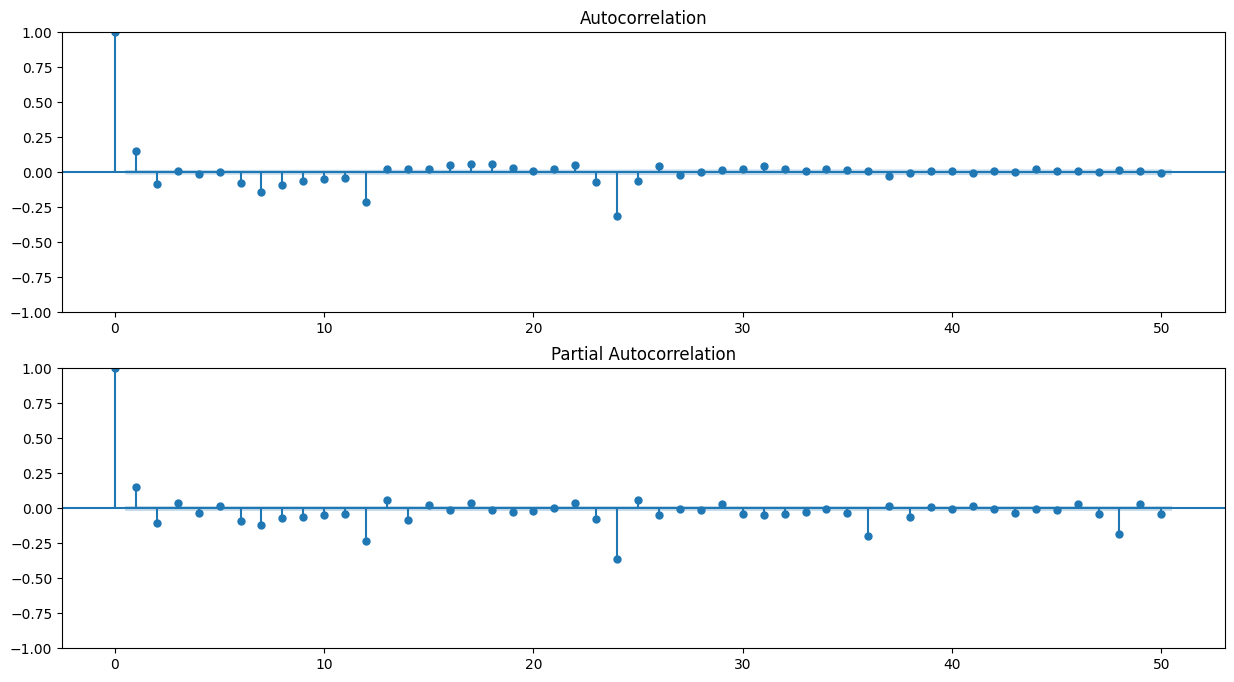

In [26]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

res = sarima_model.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

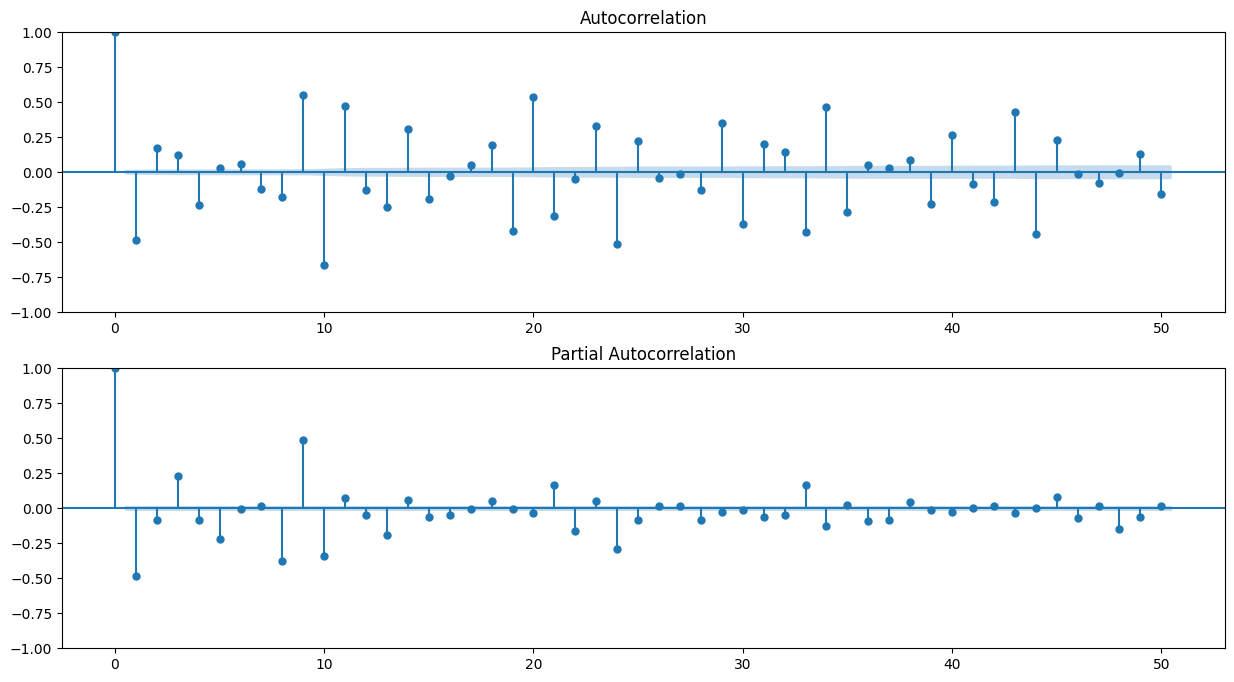

In [27]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

res = sarima_model_y.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

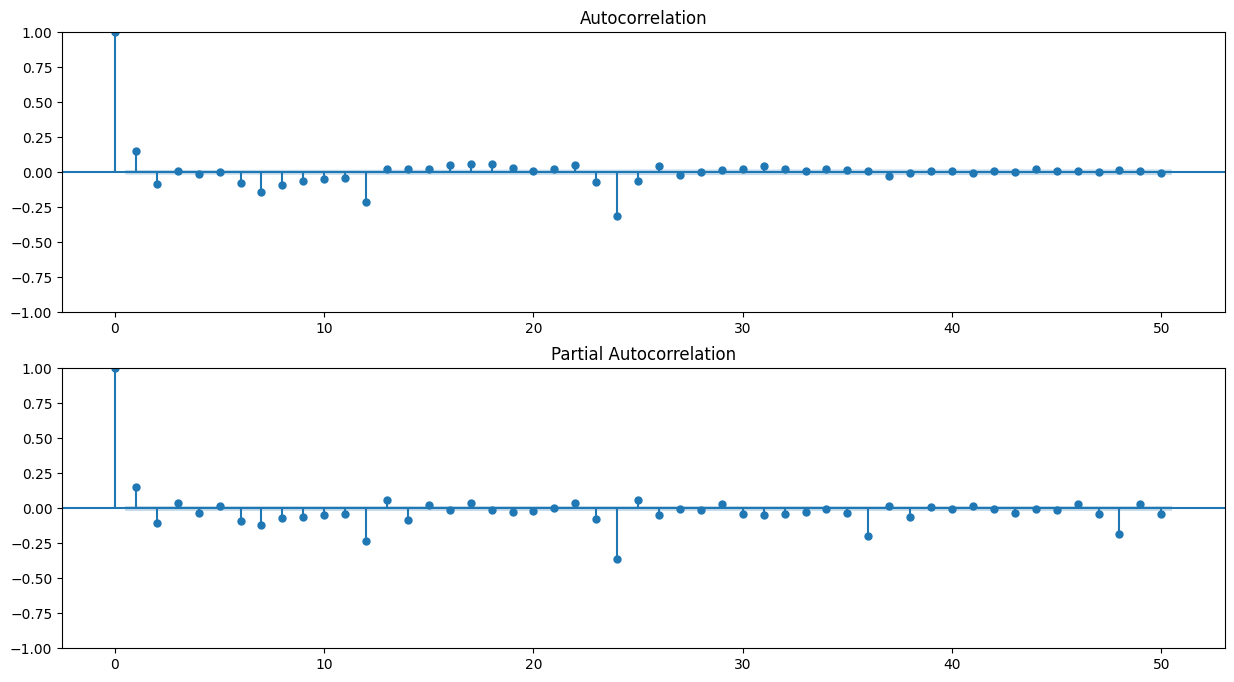

In [28]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

res = sarima_model_z.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

### Наше любимое MSE

In [33]:
from sklearn.metrics import mean_squared_error
pred = sarima_model.predict(1,len(validation_data))[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(validation_data[1:],pred)))

SARIMA model MSE:4.0433108224602713e-16


In [40]:
from sklearn.metrics import mean_squared_error
pred_y = sarima_model_y.predict(1,len(validation_data_y))[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(validation_data_y[1:],pred)))

SARIMA model MSE:1.3771155112583359e-15


In [36]:
from sklearn.metrics import mean_squared_error
pred_z= sarima_model_z.predict(1,len(validation_data_z))[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(validation_data_z[1:],pred)))

SARIMA model MSE:6.344924689350178e-16


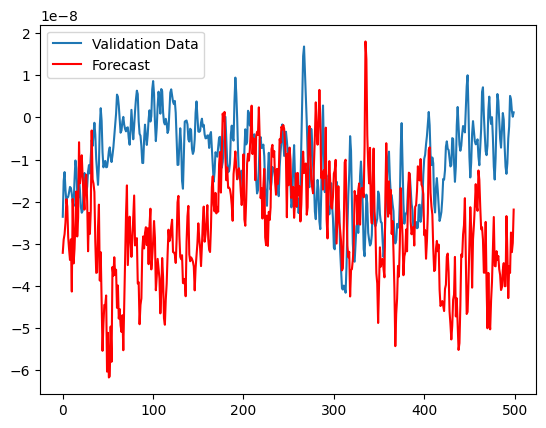

In [44]:
import matplotlib.pyplot as plt

# График валидационных данных
plt.plot(validation_data[:500], label='Validation Data')

# График прогноза для валидационных данных
plt.plot(pred[:500], label='Forecast', color='red')

plt.legend()
plt.show()


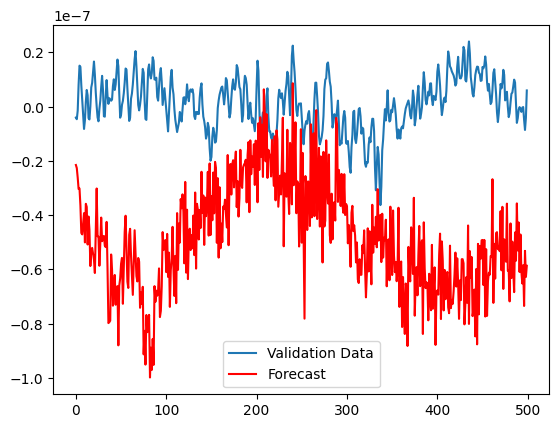

In [47]:
import matplotlib.pyplot as plt

# График валидационных данных
plt.plot(validation_data_y[:500], label='Validation Data')

# График прогноза для валидационных данных
plt.plot(pred_y[:500], label='Forecast', color='red')

plt.legend()
plt.show()

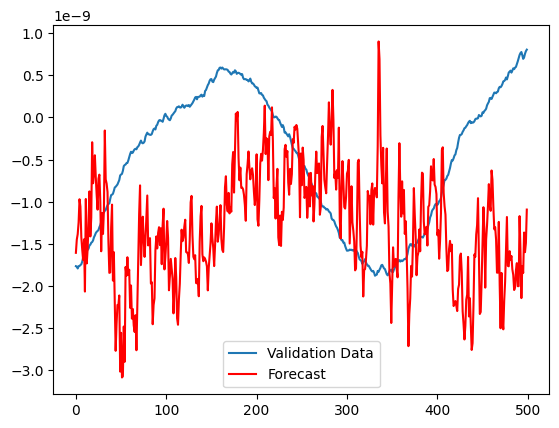

In [51]:
import matplotlib.pyplot as plt

# График валидационных данных
plt.plot(validation_data_z[:500], label='Validation Data')

# График прогноза для валидационных данных
plt.plot(pred_z[:500] / 20, label='Forecast', color='red')

plt.legend()
plt.show()

### Сохранение модели

In [32]:
import joblib

# Сохранение модели в файл
joblib.dump(sarima_model, 'sarima_model.pkl')

['sarima_model.pkl']

In [48]:
import joblib

# Сохранение модели в файл
joblib.dump(sarima_model_y, 'sarima_model_y.pkl')

['sarima_model_y.pkl']

In [49]:
import joblib

# Сохранение модели в файл
joblib.dump(sarima_model_z, 'sarima_model_z.pkl')

['sarima_model_z.pkl']